In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_json("experiments.jsonl", lines=True)
print(len(df))
df.head()

392


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,3ddffbe7f93b656485c8735c86e935dc825f48c7,worse-yolk,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,cte/excellent-format-few,cq,empty.json,...,0.017377,0.023292,0.027157,0.035213,0.006579,0.011827,0.007407,0.007956,CTE,0
1,10440a288bbffcf1b996a4ae93829166dc0d2f24,often-grot,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.0,cte/format-few,cq,empty.json,...,0.568887,0.692932,0.615815,0.742782,0.551316,0.695246,0.456790,0.534483,CTE,0
2,914c58822a6a22fe9562d07d6210aa038c68710d,sural-zoon,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.0,cte/excellent-format-few,cq,empty.json,...,0.540339,0.654402,0.580671,0.699737,0.538158,0.659919,0.419753,0.503899,CTE,0
3,99a285fedd0ce75fcf51b89c817d42bba44d7772,world-tads,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal,cq,empty.json,...,0.000000,0.000241,0.000000,0.000465,0.000000,0.000000,0.000000,0.000000,Standard,0
4,9ff91b866b34230fa372ecc1b0fcde14aeef726b,leaky-mako,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format,cq,empty.json,...,0.247000,0.349548,0.287540,0.400635,0.225000,0.332254,0.162963,0.224074,Standard,0


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]

In [4]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)
df

,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,65caa1d3e6ed1c20ba28316e2e708d82710bfd6e,moldy-tret,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.0,cot/excellent-format-reasoning,cq,empty.json,...,0.407944,0.489914,0.533546,0.625827,0.311842,0.377059,0.200000,0.281535,COT,0
1,4dcfdf2cd748a92c5fe7369b3c433bf2619fff16,shier-vans,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.0,cot/excellent-format-reasoning,cq,empty.json,...,0.407116,0.492792,0.527955,0.625286,0.310526,0.382631,0.214815,0.289931,COT,0
2,016515130c68b510a7e3a2f2d8f784dfc7f1c719,platy-banc,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.0,cot/excellent-format-reasoning,cq,empty.json,...,0.401738,0.489893,0.530351,0.627570,0.301316,0.377814,0.192593,0.274604,COT,0
3,fd47f4ffe3aa8931d5d20fedc069d3098625b578,jaggy-airt,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,cot/excellent-format-reasoning,cq,empty.json,...,0.409599,0.493538,0.535144,0.630265,0.306579,0.378292,0.214815,0.287126,COT,0
4,5e53e3b4276f0d32b37b032316cb4f655b8304f3,world-linn,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,cot/excellent-format-reasoning,cq,empty.json,...,0.405048,0.490532,0.531949,0.629372,0.307895,0.374431,0.195062,0.279196,COT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,b9c9faacda0bf2399ed924cc1e3c82a766d60b83,murky-pans,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.5,standard/minimal-output-format-fewest,cq,empty.json,...,0.527513,0.659429,0.585463,0.709983,0.517105,0.666309,0.367901,0.490239,Standard,0
388,b69f749669423413075a097d6fbee3a5728072fb,rusty-rede,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.5,standard/minimal-output-format-fewest,cq,empty.json,...,0.537029,0.661377,0.575080,0.701884,0.548684,0.677860,0.397531,0.505225,Standard,0
389,039795bf48a602f1e66a744865da09d0b46f19f0,jetty-dais,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format-fewest,cq,empty.json,...,0.271825,0.382596,0.313099,0.421900,0.260526,0.371239,0.165432,0.282405,Standard,0
390,7ed84707053258ca4420f95e3f58827fd44d3150,lived-cyst,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format-fewest,cq,empty.json,...,0.280099,0.371865,0.321885,0.418983,0.277632,0.375419,0.155556,0.219537,Standard,0


In [5]:
# Filter out experiments with F1 score < 0.1
df_filtered = df[df['metrics.f1'] >= 0.1].copy().reset_index()
df_filtered.shape

(356, 22)

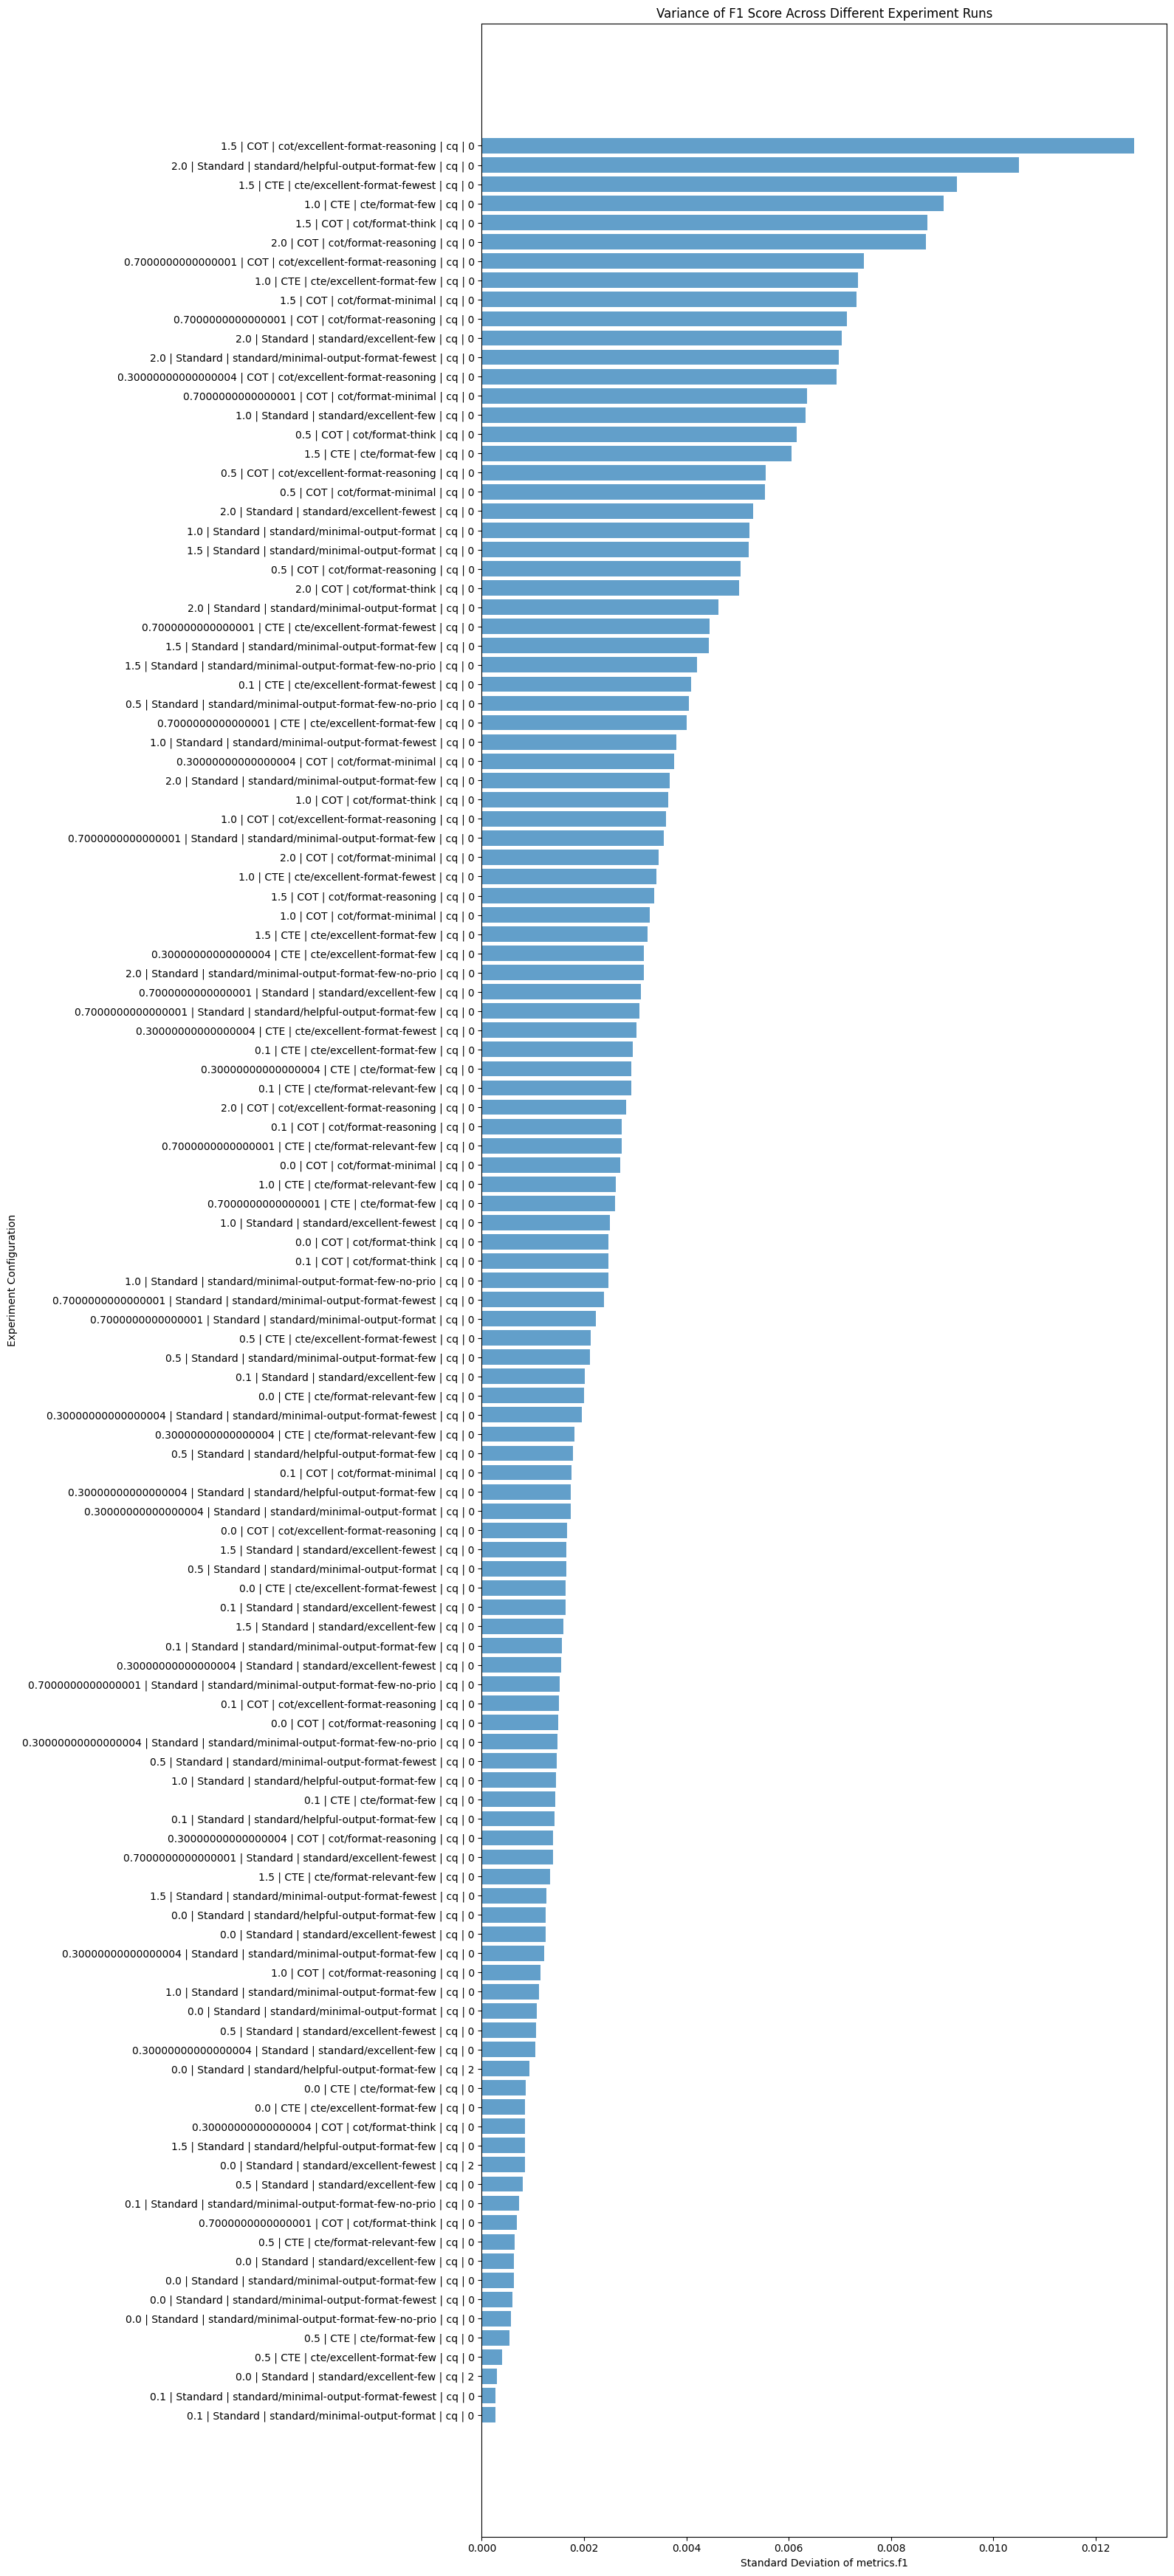

In [6]:
def plot_variance(dataf, metric_column):
    # Calculate variance of the specified metric for each experiment group
    grouped_dataf = dataf.groupby([
        'params.qa.temperature',
        'params.qa.technique',
        'params.qa.system_prompt',
        'params.qa.user_prompt_template',
        'params.qa.n_shot'
    ])[metric_column].std().reset_index()
    grouped_dataf.rename(columns={metric_column: f'{metric_column}_std'}, inplace=True)

    # Creating a unique label for each experiment configuration
    grouped_dataf['experiment_label'] = grouped_dataf[
        ['params.qa.temperature', 'params.qa.technique', 'params.qa.system_prompt', 'params.qa.user_prompt_template', 'params.qa.n_shot']
    ].apply(lambda x: ' | '.join(map(str, x)), axis=1)

    # Sort by variance for better visual clarity
    grouped_dataf.sort_values(f'{metric_column}_std', inplace=True)

    # Plot
    metric_name = metric_column.split(".")[-1].upper()
    plt.figure(figsize=(16, int(len(grouped_dataf)*0.3)))
    plt.barh(grouped_dataf['experiment_label'], grouped_dataf[f'{metric_column}_std'], alpha=0.7)
    plt.xlabel(f'Standard Deviation of {metric_column}')
    plt.ylabel('Experiment Configuration')
    plt.title(f'Variance of {metric_name} Score Across Different Experiment Runs')
    plt.tight_layout()
    plt.show()

plot_variance(df_filtered, 'metrics.f1')


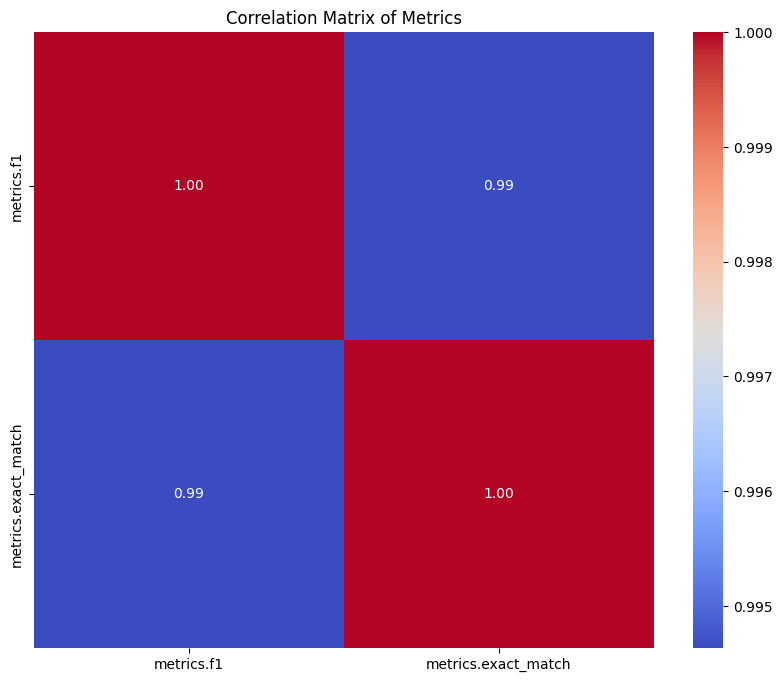

In [ ]:

def analyze_correlation(dataf, metric_columns):
    correlation_matrix = dataf[metric_columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Metrics')
    plt.show()

analyze_correlation(df_filtered, ['metrics.f1', 'metrics.exact_match'])



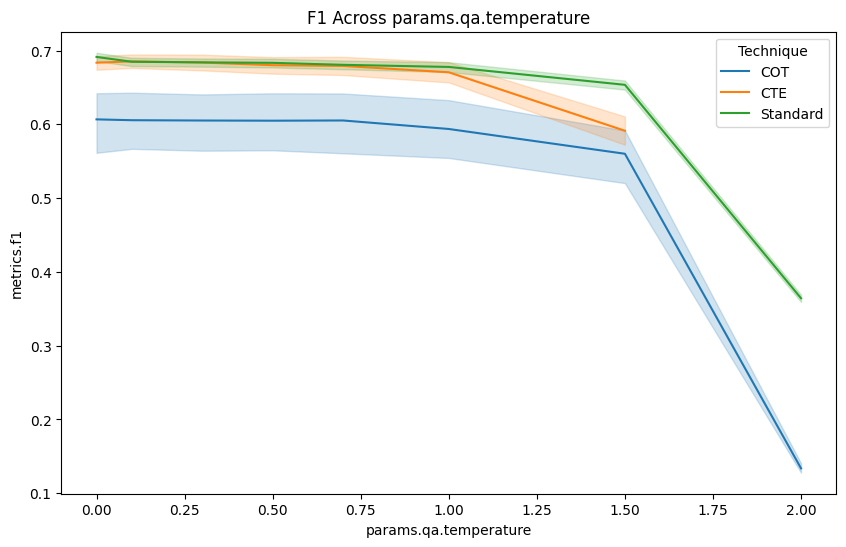

In [ ]:
def performance_trends(dataf, metric_column, parameter):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dataf, x=parameter, y=metric_column, hue='params.qa.technique')
    plt.title(f'{metric_column.split(".")[-1].capitalize()} Across {parameter}')
    plt.xlabel(parameter)
    plt.ylabel(metric_column)
    plt.legend(title='Technique')
    plt.show()

performance_trends(df_filtered, 'metrics.f1', 'params.qa.temperature')


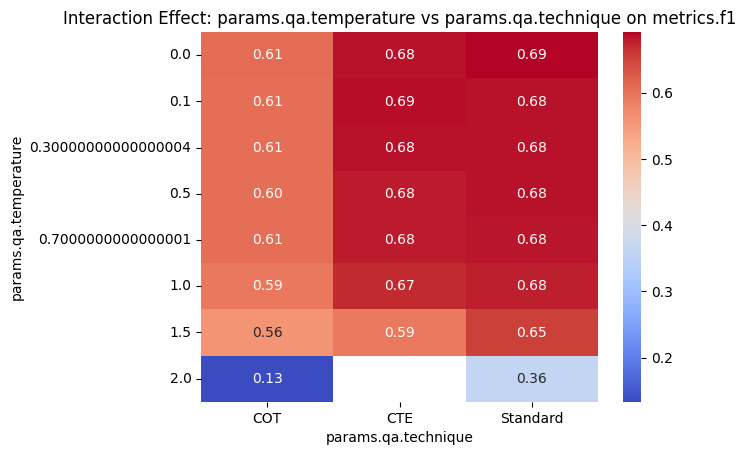

In [ ]:

def interaction_effects(dataf, metric_column, param1, param2):
    pivot_table = dataf.pivot_table(index=param1, columns=param2, values=metric_column, aggfunc='mean')
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Interaction Effect: {param1} vs {param2} on {metric_column}')
    plt.show()

interaction_effects(df_filtered, 'metrics.f1', 'params.qa.temperature', 'params.qa.technique')


In [10]:
def top_n_configurations(dataf, metric_column, n=5):
    top_configs = dataf.nlargest(n, metric_column)
    print("Top Configurations:")
    print(top_configs[[
        'params.qa.temperature',
        'params.qa.technique',
        'params.qa.system_prompt',
        'params.qa.user_prompt_template',
        'params.qa.n_shot',
        metric_column
    ]])

top_n_configurations(df_filtered, 'metrics.f1', n=5)

Top Configurations:
     params.qa.temperature params.qa.technique  \
258                    0.0            Standard   
257                    0.0            Standard   
259                    0.0            Standard   
153                    1.0                 CTE   
145                    0.3                 CTE   

                params.qa.system_prompt params.qa.user_prompt_template  \
258  standard/helpful-output-format-few                             cq   
257  standard/helpful-output-format-few                             cq   
259  standard/helpful-output-format-few                             cq   
153                      cte/format-few                             cq   
145                      cte/format-few                             cq   

     params.qa.n_shot  metrics.f1  
258                 2    0.717824  
257                 2    0.717026  
259                 2    0.715956  
153                 0    0.710135  
145                 0    0.709708  


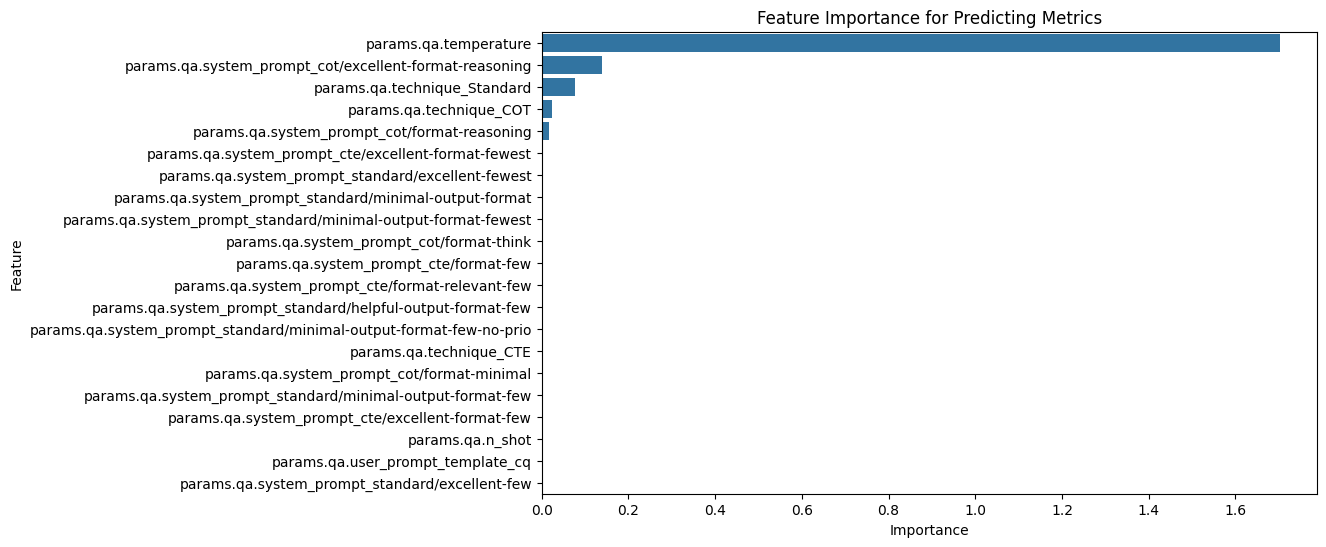

In [11]:
def feature_importance(dataf, metric_column):
    # Prepare data
    feature_columns = ['params.qa.temperature', 'params.qa.technique', 'params.qa.system_prompt', 'params.qa.user_prompt_template', 'params.qa.n_shot']
    X = pd.get_dummies(dataf[feature_columns])
    y = dataf[metric_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    importance = permutation_importance(model, X_test, y_test, random_state=42)
    importance_df = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for Predicting Metrics')
    plt.show()


# Perform analyses
feature_importance(df_filtered, 'metrics.f1')

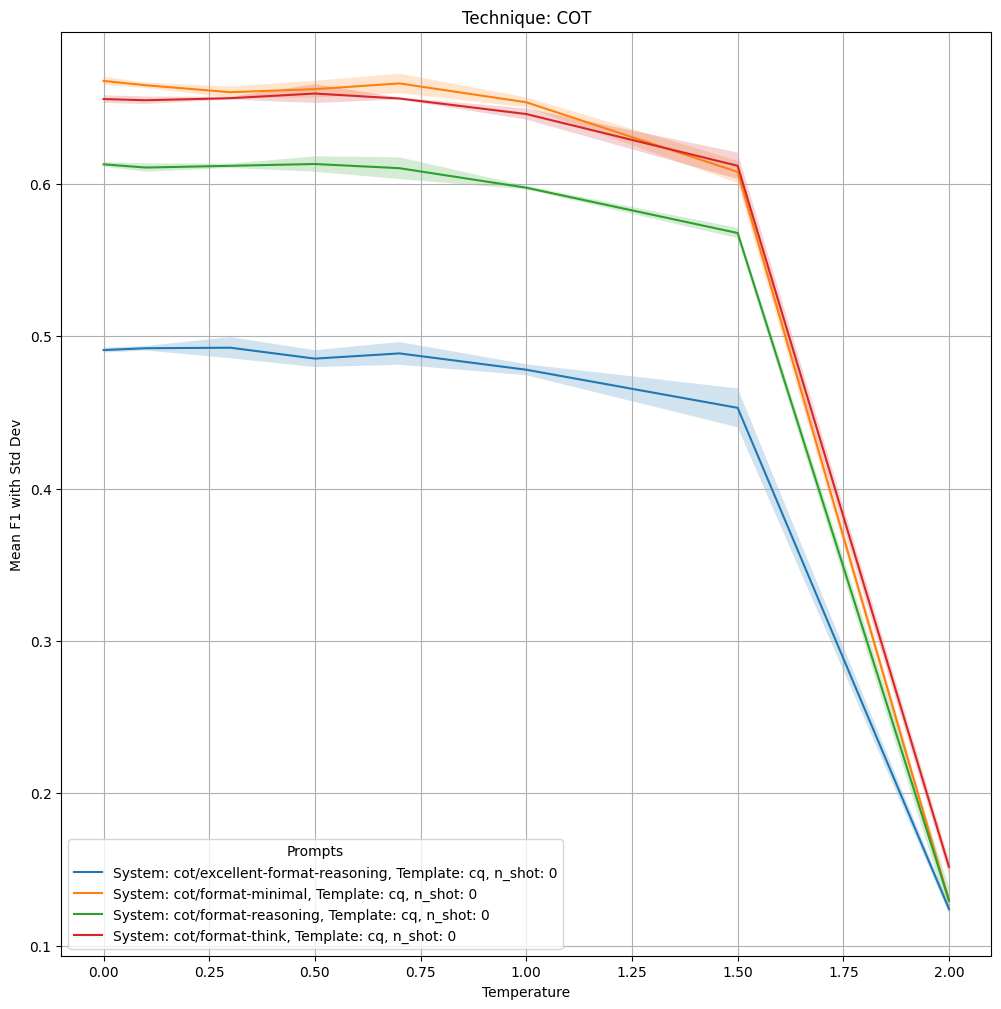

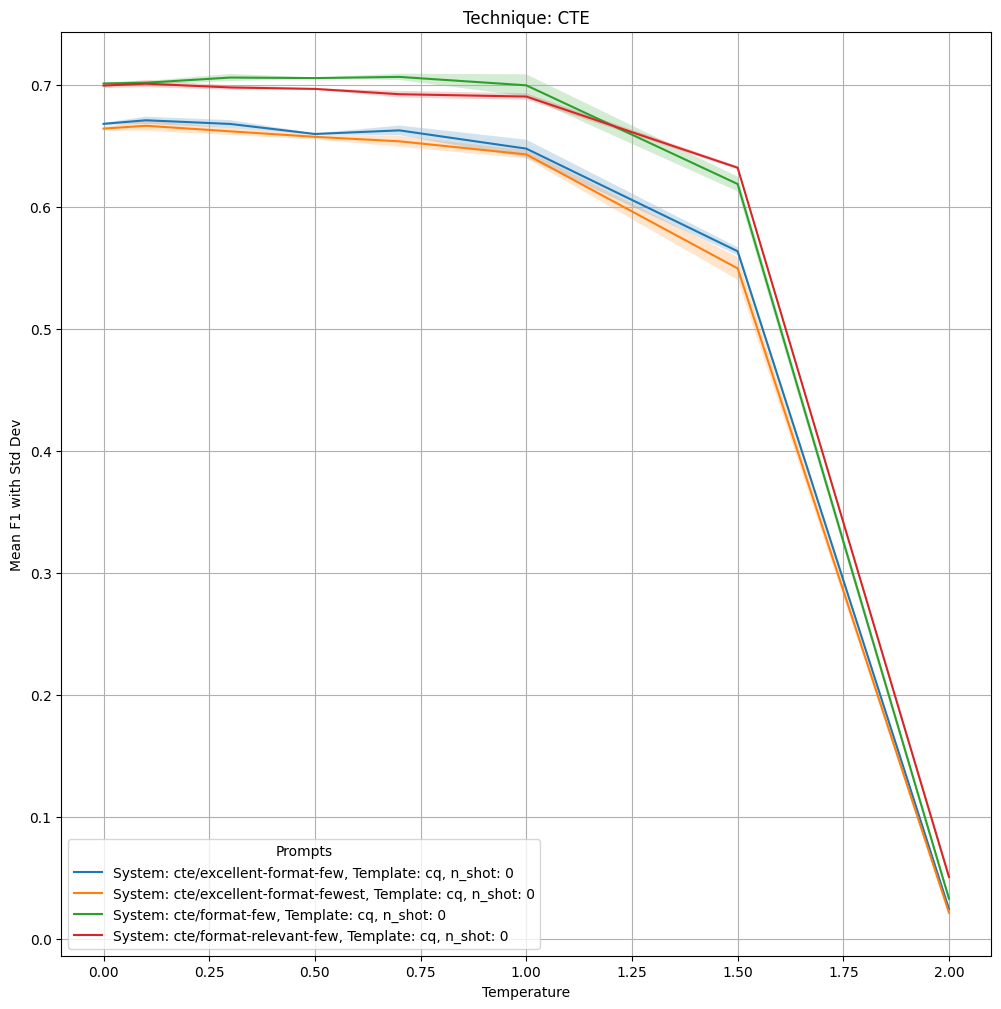

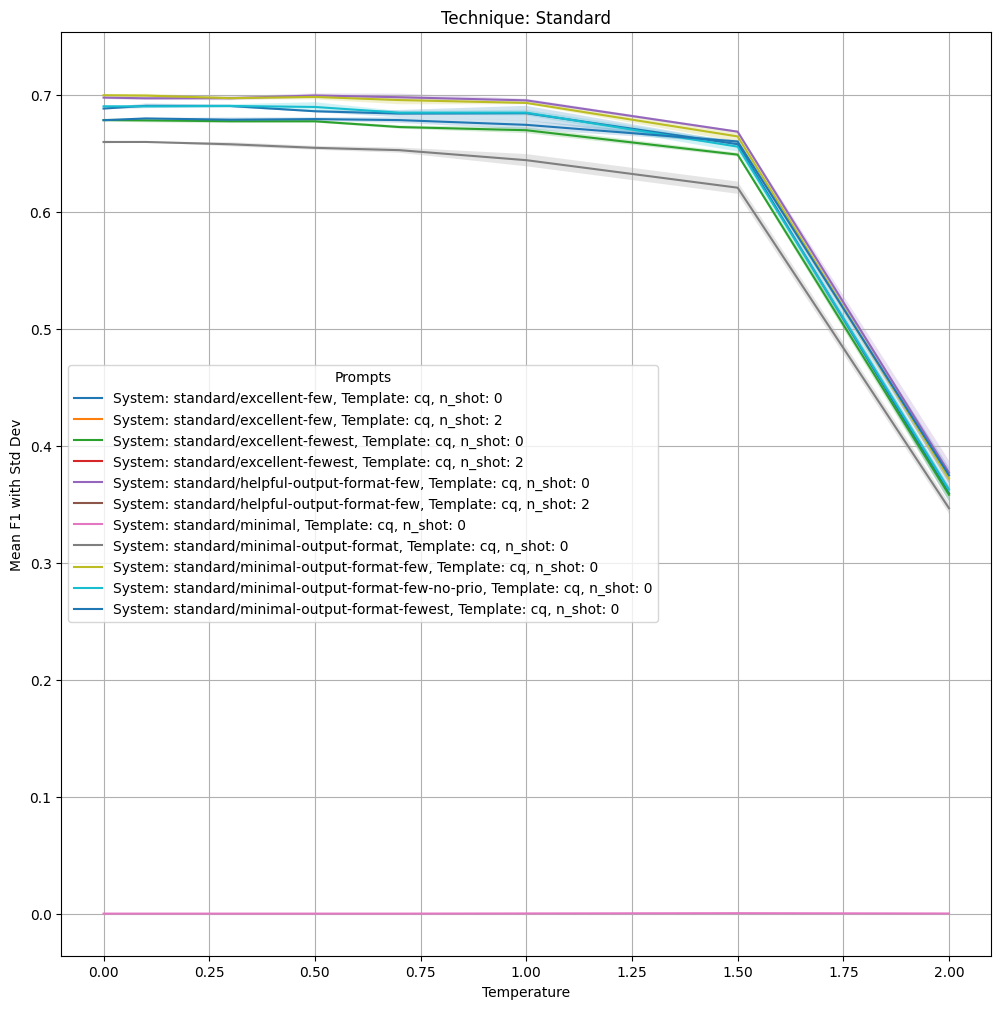

In [12]:

# Group by the variables of interest and calculate mean and std for F1 score
summary_stats = df.groupby([
    'params.qa.technique',
    'params.qa.temperature', 
    'params.qa.system_prompt', 
    'params.qa.user_prompt_template', 
    'params.qa.n_shot'
])['metrics.f1'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
summary_stats.rename(columns={'mean': 'metrics.f1_mean', 'std': 'metrics.f1_std'}, inplace=True)

# Plot mean F1 score with shaded standard deviation vs temperature for each combination of prompting variables, grouped by technique
techniques = summary_stats['params.qa.technique'].unique()

for technique in techniques:
    plt.figure(figsize=(12, 12))
    technique_data = summary_stats[summary_stats['params.qa.technique'] == technique]
    unique_prompts = technique_data.groupby([
        'params.qa.system_prompt', 
        'params.qa.user_prompt_template', 
        'params.qa.n_shot'
    ])
    for (system_prompt, user_prompt_template, n_shot), group in unique_prompts:
        plt.plot(group['params.qa.temperature'], group['metrics.f1_mean'], label=f"System: {system_prompt}, Template: {user_prompt_template}, n_shot: {n_shot}")
        plt.fill_between(group['params.qa.temperature'], 
                         group['metrics.f1_mean'] - group['metrics.f1_std'], 
                         group['metrics.f1_mean'] + group['metrics.f1_std'], 
                         alpha=0.2)
    plt.title(f"Technique: {technique}")
    plt.xlabel('Temperature')
    plt.ylabel('Mean F1 with Std Dev')
    plt.legend(title="Prompts")
    plt.grid()
    plt.show()
